# Graph preprocessing

In this notebook we generate the large actor graph

Actors $i \in \{1 \cdots N\}$. Actor nodes store their corresponding fbid.

Edges $(i,j) \in E$ iff $i$ and $j$ have played in the same movie. Edges store a list of movie fbids in which both actors have played

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import itertools

## Load preprocessed data

In [2]:
df_actors = pd.read_pickle('../data/generated/preprocessed/characters.pkl')

## Generate edges

### Raw ordered edges, without grouping

In [3]:
edges = []

for movie_fbid, df_actor_movie in df_actors.dropna(subset=['fb_actor_id']).groupby('fb_movie_id'):
	# NOTE : we need to sort the edges, because we only store i -> j, but want an undirected graph
	# NOTE : we need to use unique(), because some actors play multiple characters in the same movie
	# e.g. df_actors.query('fb_movie_id == "/m/011xrr"')
	edges += [ (*sorted((actor1_fbid, actor2_fbid)), movie_fbid )
		for actor1_fbid, actor2_fbid in itertools.combinations(df_actor_movie.fb_actor_id.unique(), r=2) ]

df_edges = pd.DataFrame(edges, columns=['actor1_fbid', 'actor2_fbid', 'movie_fbid'])

In [4]:
# sanity check that we indeed have ordered edges
assert (df_edges['actor1_fbid'] < df_edges['actor2_fbid']).all()
df_edges

,actor1_fbid,actor2_fbid,movie_fbid
0,/m/01lc5,/m/07mmg5,/m/011_mj
1,/m/01lc5,/m/0ksm_r,/m/011_mj
2,/m/01lc5,/m/03d36rf,/m/011_mj
3,/m/01lc5,/m/0gclz8m,/m/011_mj
4,/m/01lc5,/m/043j_fq,/m/011_mj
...,...,...,...
2241652,/m/03cs7zg,/m/0gc19fb,/m/0yzvw
2241653,/m/03cs7zg,/m/05ztnvq,/m/0yzvw
2241654,/m/08d8dtg,/m/0gc19fb,/m/0yzvw
2241655,/m/05ztnvq,/m/08d8dtg,/m/0yzvw


In [5]:
df_edges.to_pickle('../data/generated/graph/actor_graph_full.ungrouped.pkl')

### Ordered edges, grouped by actor pairs

In [6]:
df_edges_grouped = (df_edges
	.groupby(['actor1_fbid', 'actor2_fbid'])
	[['movie_fbid']]
	.count()
	.reset_index()
	.sort_values('movie_fbid', ascending=False)  # movie_fbid count is the edge weight !!
)
df_edges_grouped.rename(columns={'movie_fbid': 'movie_count'}, inplace=True)
df_edges_grouped.head(20)

,actor1_fbid,actor2_fbid,movie_count
503637,/m/02cvp8,/m/02t0n9,219
655465,/m/02t0n9,/m/045g4l,119
503747,/m/02cvp8,/m/045g4l,119
906950,/m/03mv0b,/m/0lh0c,101
503668,/m/02cvp8,/m/030dx5,82
655389,/m/02t0n9,/m/030dx5,82
413851,/m/026xmsr,/m/02cvp8,72
413858,/m/026xmsr,/m/02t0n9,72
434488,/m/027_zc,/m/0671gz,60
1039042,/m/04c636,/m/05yvfd,59


In [7]:
print(f'N={pd.concat([df_edges_grouped.actor1_fbid, df_edges_grouped.actor2_fbid]).nunique()} nodes, E={len(df_edges_grouped)} edges')

N=135061 nodes, E=2080273 edges


In [8]:
df_edges_grouped.to_pickle('../data/generated/graph/actor_graph_full.grouped.pkl')

## Create graph

### Using networkx

In [9]:
import networkx as nx

In [10]:
g = nx.from_pandas_edgelist(df_edges_grouped, source='actor1_fbid', target='actor2_fbid', edge_attr=['movie_count'])
print(g)

Graph with 135061 nodes and 2080273 edges


### Using igraph

In [11]:
import igraph as ig

In [12]:
# we need to convert to numerical indices, otherwise igraph will complain
codes, uniques = pd.factorize(pd.concat([df_edges_grouped.actor1_fbid, df_edges_grouped.actor2_fbid]))
df_edges_ig = df_edges_grouped.copy()
df_edges_ig['actor1_numid'] = codes[:len(df_edges_ig)]
df_edges_ig['actor2_numid'] = codes[len(df_edges_ig):]
df_edges_ig

,actor1_fbid,actor2_fbid,movie_count,actor1_numid,actor2_numid
503637,/m/02cvp8,/m/02t0n9,219,0,1
655465,/m/02t0n9,/m/045g4l,119,1,253
503747,/m/02cvp8,/m/045g4l,119,0,253
906950,/m/03mv0b,/m/0lh0c,101,2,69600
503668,/m/02cvp8,/m/030dx5,82,0,40
...,...,...,...,...,...
717939,/m/02z28y7,/m/09rxk8z,1,1079,19808
717938,/m/02z28y7,/m/09rvxt5,1,1079,19881
717937,/m/02z28y7,/m/09q3gc,1,1079,5279
717936,/m/02z28y7,/m/09jlgq,1,1079,12708


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
df_actors = pd.read_pickle("../data/generated/preprocessed/actors.pkl")

In [44]:
g = ig.Graph.DataFrame(df_edges_ig[['actor1_numid', 'actor2_numid', 'movie_count']], directed=False)
# g = ig.Graph.DataFrame(df_edges[['actor1_fbid', 'actor2_fbid', 'movie_count']], directed=False, use_vids=False)  # without using numerical ids!
g.vs['actor_fbid'] = uniques
g.vs['actor_evcentrality'] = g.eigenvector_centrality(weights = g.es["movie_count"])
g.vs['actor_betweenness'] = g.betweenness(weights = g.es["movie_count"])


vertices = {'fb_actor_id': g.vs["actor_fbid"], 
            'evcentrality': g.vs["actor_evcentrality"],
            'betweenness': g.vs["actor_betweenness"]}
df_vertices = pd.DataFrame(vertices)

AttributeError: 'Graph' object has no attribute 'betweenness_estimate'

In [40]:
df_actor_centrality = pd.merge(df_actors.loc[df_actors.pageviews.notna()], df_vertices, on="fb_actor_id", how="inner")

/home/dario/.conda/envs/ada/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


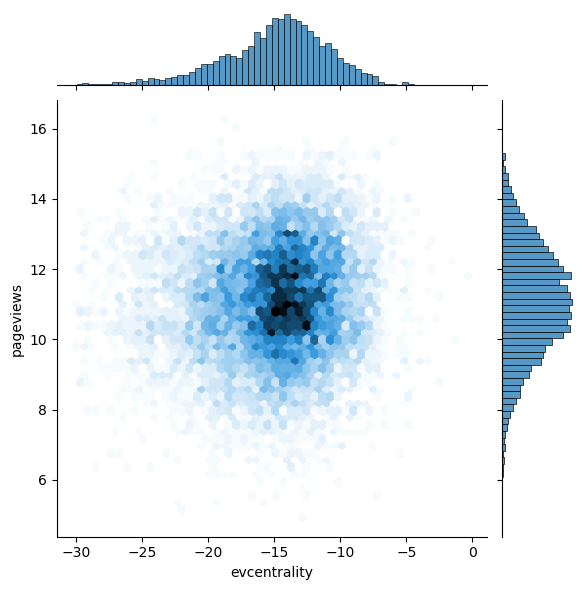

In [41]:
df_subset = df_actor_centrality.loc[np.log(df_actor_centrality.evcentrality) > -30]
g = sns.jointplot(x=np.log(df_subset.evcentrality), y=np.log(df_subset.pageviews), kind="hex")

In [42]:
df_subset = df_actor_centrality.loc[np.log(df_actor_centrality.betweenness) > -30]
g = sns.jointplot(x=np.log(df_subset.betweenness), y=np.log(df_subset.pageviews), kind="hex")

AttributeError: 'DataFrame' object has no attribute 'betweenness'